# Living Coasts Information and Training <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/ga_ls_landcover_class_cyear_2)


## Extracting an area based on an area of interest defined using a geojson.

Through Geoscience Australia's (GA) Digital Earth Australia (DEA) Land Cover, land cover maps have been generated for 34 years (1988 to 2020) from environmental descriptors retrieved or classified entirely from Landsat sensor data and according to the Food and Agriculture Organisation (FAO) Land Cover Classification System (Version 2).  The spatial resolution of the mapping is 25 m 
(see DEA Land Cover) at https://cmi.ga.gov.au/data-products/dea/607/dea-land-cover-landsat)

This notebooks allows you to create a geojson file created from the website https://geojson.io/ and to bring this to extract a specific area of the land cover and other environmental descriptors.  

## Description 

The notebooks take you through the process of:

1. Reading the geojson file and extracting the geometry.
2. Extracting the DEA land cover map and associated environmental descriptors.
3. View the time-series of land cover maps for selected years.
4. Select a specific year for viewing.
5. Export the data to a geotiff for viewing in QGIS (style-files are available in /uploads/style/).

If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

## Section 1:  Setup

In [3]:
# Initial imports and setup
import sys
import os, re
import datacube
import datetime as dt
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors
import matplotlib as mpl
import cmocean # for intertidal products
import odc.geo.xr # RML
import pandas as pd
import rioxarray
import warnings
import xarray as xr

#from dea_tools.landcover import lc_colourmap, make_colorbar, plot_land_cover
from dea_tools.plotting import display_map, rgb, xr_animation # Added xr_animation RML

from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import Geometry
from datetime import datetime, timedelta
from ipyleaflet import DrawControl, FullScreenControl, LayersControl, Map, Rectangle, WidgetControl, basemaps # Added rectangle RML
from ipywidgets import Button, Dropdown, FloatText, GridspecLayout, Layout, HBox, VBox, Output, Tab, interact, widgets
from IPython.display import HTML, display
from IPython.core.display import Video
from pyproj import Proj, transform
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
from time import time
warnings.filterwarnings("ignore")

# Setup paths and Datacube instance
#import sys
#sys.path.insert(1, "/home/Tools")

dc = datacube.Datacube()
time_range = None

sys.path.append("../Working")
import display_tools
from display_tools import display_da
from landcover import lc_colourmap, make_colorbar, plot_land_cover

# Ensure openpyxl is installed
!pip install openpyxl


## Web-based delineation and saving of an AOI 
Visit https://geojson.io/ and then delineate either a box or a polygon for your area of interest.
Save this as a geojson file and then put into the uploads directory (e.g., uploads/AOI).

In [4]:
# Additional libraries etc.

from datacube.utils.geometry import Geometry, CRS
from ipyleaflet import GeoData
from display_tools import map_geom, rgb

sys.path.append("../Tools/wdc_tools")
from wdc_datahandling import geopolygon_masking

## Section 2: Ingesting the geojson file for your area of interest
Load the geojson file from the uploads directory (e.g., uploads/AOI) and then run the following cells. 

In [5]:
# add in vector data for area of interest
Area = 'uploads/AOIs/Fitzroy-riverbend.geojson'
#Area = 'uploads/AOIs/Stradbroke-Island-north.json'
Area = gpd.read_file(Area)

In [6]:
display_map(x=(Area.total_bounds[0], Area.total_bounds[2]), y=(Area.total_bounds[1], Area.total_bounds[3]))

In [7]:
# Loop through polygons in geodataframe and extract satellite data
for index, row in Area.iterrows(): 
    # Extract the feature's geometry as a datacube geometry object (this needs to be updated eventually for Shapely 2.0)
    geom = Geometry(geom=row.geometry, crs=Area.crs)
#    geom = Geometry(geom=Area.iloc[0].geometry, 
#                         crs=CRS("epsg:32755"))    
    # Update the query to include our geopolygon
    query = {'geopolygon': geom
        }

# Generate land cover summaries

In [6]:
# Load land cover data for our polygon and time period
#lc_dataset = dc.load(product='lw_landcover_lw', **query)
#lc_dataset_masked = geopolygon_masking(lc_dataset, geopolygon=geom)

# Step 3: Load DEA Land Cover data from the datacube
try:
    lc = dc.load(
        product="ga_ls_landcover_class_cyear_2",
        output_crs="EPSG:32755",
        measurements=[
            "level3",
            "lifeform",
            "vegetation_cover",
            "water_seasonality",
            "water_state",
            "intertidal",
            "water_persistence",
            "bare_gradation",
            "full_classification",
        ],
        resolution=(-25, 25),
        **query
    )
    print("Data loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading data from the datacube: {e}")
    
lc_dataset_masked = geopolygon_masking(lc, geopolygon=geom)

Data loaded successfully.


In [7]:
# Load land cover data for our polygon and time period
#lc_dataset = dc.load(product='lc', **query)
lc_masked = geopolygon_masking(lc, geopolygon=geom)

In [8]:
# Section 6: Checkbox widgets for selecting datasets
level3_checkbox = widgets.Checkbox(description='Level 3', value=False)
lifeform_checkbox = widgets.Checkbox(description='Lifeform', value=False)
vegetation_cover_checkbox = widgets.Checkbox(description='Vegetation Cover', value=False)
water_state_checkbox = widgets.Checkbox(description='Water State', value=False)
water_persistence_checkbox = widgets.Checkbox(description='Water Persistence', value=False)
full_classification_checkbox = widgets.Checkbox(description='Full Classification', value=False)
item_checkbox = widgets.Checkbox(description='Intertidal Elevation', value=False)

output = widgets.Output()

def plot_selected_datasets():
    with output:
        output.clear_output()
        selected_datasets = []
        if level3_checkbox.value:
            selected_datasets.append('level3')
        if lifeform_checkbox.value:
            selected_datasets.append('lifeform')
        if vegetation_cover_checkbox.value:
            selected_datasets.append('vegetation_cover')
        if water_state_checkbox.value:
            selected_datasets.append('water_state')
        if water_persistence_checkbox.value:
            selected_datasets.append('water_persistence')            
        if full_classification_checkbox.value:
            selected_datasets.append('full_classification')
        if item_checkbox.value:
            selected_datasets.append('item')

        for dataset in selected_datasets:
            plt.figure()
            if dataset == 'level3':
                plot_land_cover(lc_masked.level3)
            elif dataset == 'lifeform':
                plot_land_cover(lc_masked.lifeform)
            elif dataset == 'vegetation_cover':
                plot_land_cover(lc_masked.vegetation_cover)
            elif dataset == 'water_state':
                plot_land_cover(lc_masked.water_state)
            elif dataset == 'water_persistence':
                plot_land_cover(lc_masked.water_persistence)
            elif dataset == 'full_classification':
                plot_land_cover(lc_masked.full_classification)
            elif dataset == 'item':
                plot_land_cover(item.elevation[0])
            plt.show()

plot_datasets_button = widgets.Button(description='Plot Selected Data')
plot_datasets_button.on_click(lambda b: plot_selected_datasets())

checkboxes_box = widgets.HBox([
    level3_checkbox, 
    lifeform_checkbox, 
    vegetation_cover_checkbox, 
    water_state_checkbox, 
    water_persistence_checkbox, 
    full_classification_checkbox,
    item_checkbox
])
display(checkboxes_box)
display(plot_datasets_button)
display(output)

Button(description='Plot Selected Data', style=ButtonStyle())

Output()

In [11]:
lc_masked.full_classification

<xarray.DataArray 'full_classification' (time: 33, y: 807, x: 794)> Size: 85MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 264B 1988-01-01 1989-01-01 ... 2020-01-01
  * y            (y) float64 6kB 6.961e+06 6.961e+06 ... 6.941e+06 6.941e+06
  * x            (x) float64 6kB 1.129e+06 1.129e+06 ... 1.149e+06 1.149e+06
    spatial_ref  int32 4B 32755
Attributes:
    units:         1
    nodata:        0
    crs:           EPSG:32755
    grid_mapping:  spatial_ref

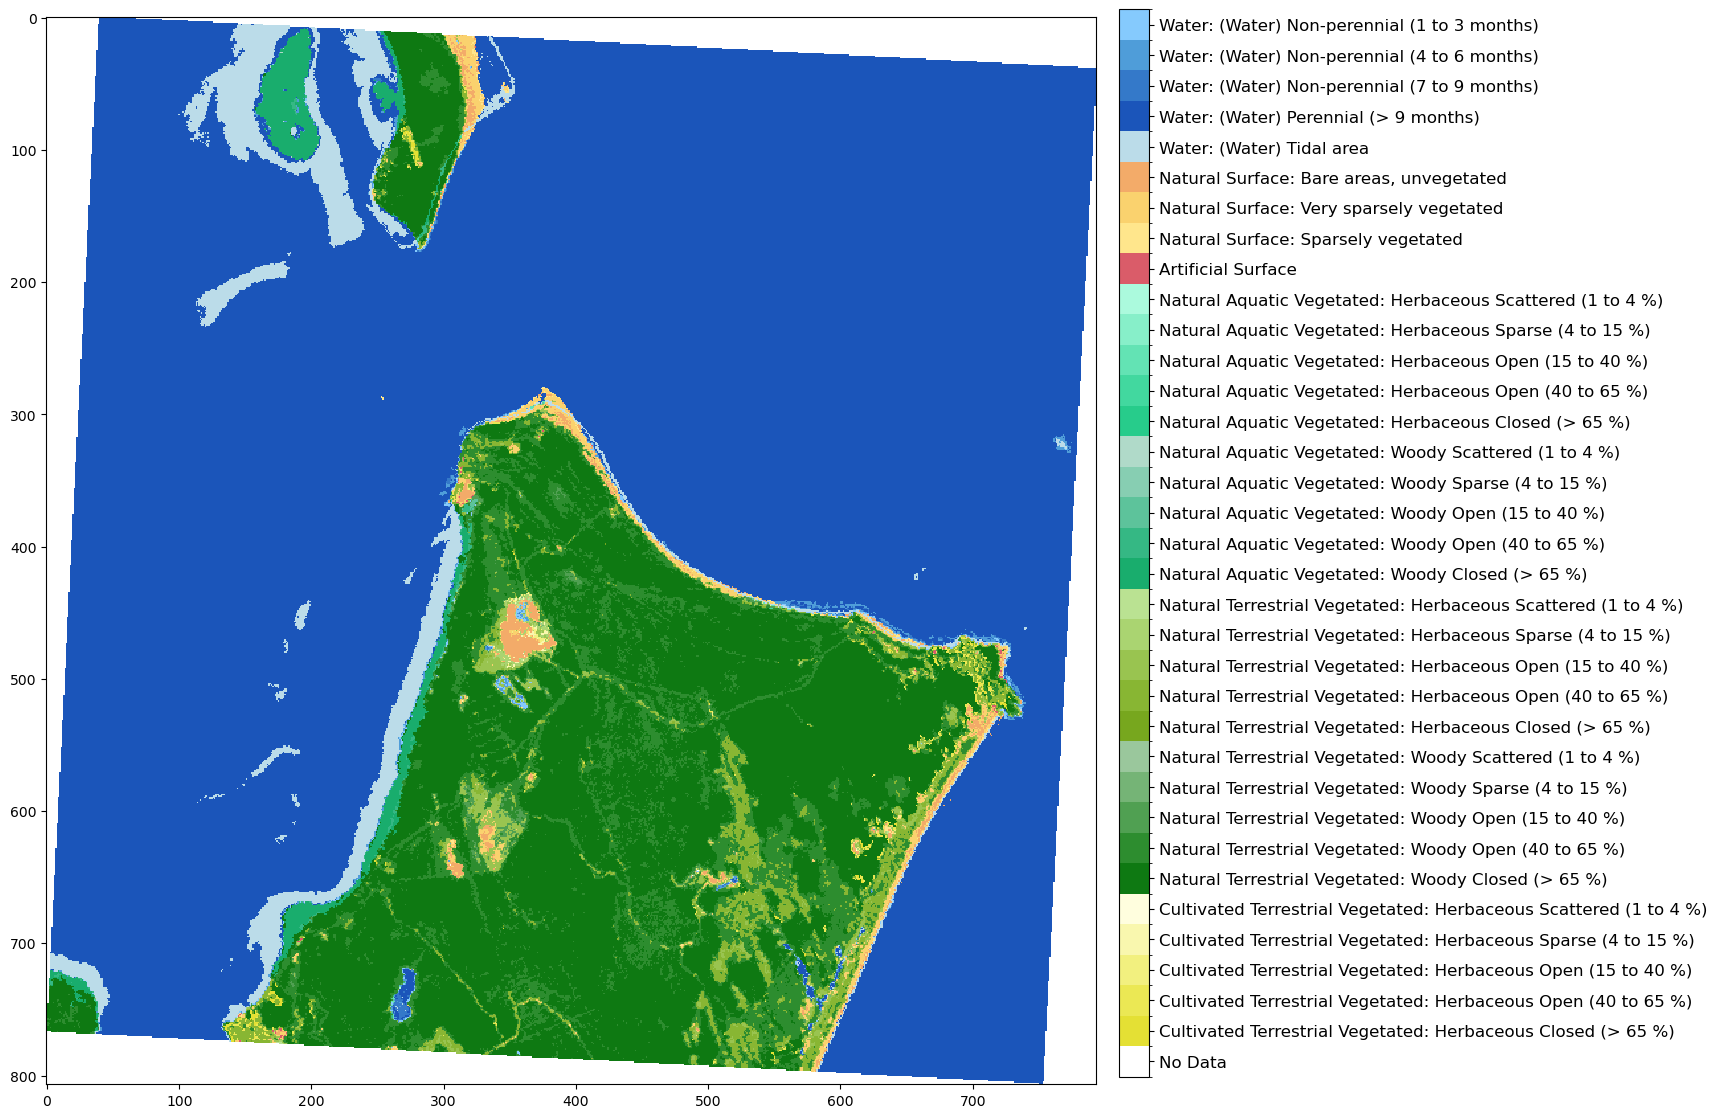

In [12]:
plot_land_cover(lc_masked.full_classification.sel(time='1988'))

#### Export to a Geotiff

In [13]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF to a location
write_cog(geo_im=lc_masked.full_classification.sel(time='2020'),
fname='./outputs/Starcke-fullclassification_2020.tif',overwrite=True)

PosixPath('outputs/Starcke-fullclassification_2020.tif')

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`sandbox compatible`, :index:`landsat 5`, :index:`landsat 7`, :index:`landsat 8`, 
:index:`DEA Land Cover`, :index:`time series`, :index: `LCCS`, :index:`colour maps`, :index:`data visualisation`